## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import pickle
from mlxtend.data import loadlocal_mnist

## Setting Numpy Seed

In [2]:
np.random.seed(10)

## Processing MNIST Dataset

In [3]:
def process_mnist_data() -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    mnist_path = './MNIST/'
    train_images, train_labels = loadlocal_mnist(
        images_path = mnist_path + './train-images.idx3-ubyte',
        labels_path = mnist_path + './train-labels.idx1-ubyte'
    )
    test_images, test_labels = loadlocal_mnist(
        images_path = mnist_path + './t10k-images.idx3-ubyte',
        labels_path = mnist_path + './t10k-labels.idx1-ubyte'
    )
    return train_images, train_labels, test_images, test_labels

## Processing CIFAR-10 Dataset

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

In [5]:
def process_cifar_dataset() -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    cifar_path = './cifar-10-python/cifar-10-batches-py'
    data_batch = unpickle(cifar_path + '/data_batch_1')
    train_images, train_labels = data_batch[b'data'], np.array(data_batch[b'labels'])
    for i in range(2,6):
        data_batch = unpickle(cifar_path + '/data_batch_' + str(i))
        train_images = np.concatenate((train_images, data_batch[b'data']), axis=0)
        train_labels = np.concatenate((train_labels, np.array(data_batch[b'labels'])), axis=0)
    test_batch = unpickle(cifar_path + '/test_batch')
    test_images, test_labels = test_batch[b'data'], np.array(test_batch[b'labels'])
    return train_images, train_labels, test_images, test_labels

## Processing Toy Dataset

In [6]:
def process_toy_dataset():
    toy_dataset_path = './Toy Dataset/'
    a = np.loadtxt(toy_dataset_path + 'trainNN.txt')
    b = np.loadtxt(toy_dataset_path + 'testNN.txt')
    train_x, train_y, test_x, test_y = a[:, 0:4], a[:, -1], b[:, 0:4], b[:, -1]
    return train_x, train_y, test_x, test_y

In [7]:
x_train_toy, y_train_toy, x_test_toy, y_test_toy = process_toy_dataset()
toy_batch_1 = x_train_toy[0:50].reshape(50, 1, 2, 2)
toy_batch_1[0, 0, :, :]

array([[ 9.21323266, 11.82445528],
       [16.69098092, 19.56967227]])

In [8]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(1,5))
toy_labels_1 = label_binarizer.transform(y_train_toy[0:50].T)
toy_labels_1

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1,

## Parsing Input Model

In [9]:
def parse_input_model():
    path = './input_model.txt'
    model = []
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            tokens = line.split()
            if tokens[0] == 'Conv':
                model.append(ConvolutionLayer(int(tokens[1]), int(tokens[2]), int(tokens[3]), int(tokens[4])))
            if tokens[0] == 'ReLU':
                model.append(ActivationLayer())
            if tokens[0] == 'Pool':
                model.append(MaxPoolingLayer(int(tokens[1]), int(tokens[2])))
            if tokens[0] == 'FC':
                model.append(FlatteningLayer())
                model.append(FullyConnectedLayer(int(tokens[1])))
            if tokens[0] == 'Softmax':
                model.append(SoftmaxLayer())
        return model

## ReLU Function

In [10]:
def relu(matrix:np.ndarray) -> np.ndarray:
    return matrix * (matrix > 0)

## Convolution Layer

In [11]:
class ConvolutionLayer:
    def __init__(self, output_channel_count: int, filter_dimension: int, stride: int, padding: int):
        self.output_channel_count = output_channel_count
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.padding = padding

    def forward(self, input_image: np.ndarray) -> np.ndarray:
        input_dimentions = input_image.shape[0]
        output_dimentions = (input_dimentions - self.filter_dimension + 2 * self.padding) // self.stride + 1
        input_shape = input_image.shape

        filters = np.random.rand(
            self.output_channel_count,
            self.filter_dimension,
            self.filter_dimension,
            input_shape[2]
        )

        bias = np.random.rand(self.output_channel_count)

        padded_image = np.pad(input_image, [(self.padding,self.padding), (self.padding,self.padding), (0,0)], mode='constant') * 1.0
        padded_image /= 255.0
        padded_dimensions = padded_image.shape

        output = np.zeros((output_dimentions, output_dimentions, self.output_channel_count))

        image_y = out_y = 0
        while image_y + self.filter_dimension <= padded_dimensions[1]:
            image_x = out_x = 0
            while image_x + self.filter_dimension <= padded_dimensions[0]:
                image_slice = padded_image[image_x:image_x+self.filter_dimension, image_y:image_y+self.filter_dimension, :]
                output[out_x, out_y, :] = np.sum(image_slice * filters) + bias
                image_x += self.stride
                out_x += 1
            image_y += self.stride
            out_y += 1

        return output

    def backward(self):
        pass

In [12]:
class ConvolutionLayerBatch:
    def __init__(self, output_channel_count: int, filter_dimension: int, stride: int, padding: int):
        self.output_channel_count = output_channel_count
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.padding = padding

    def forward(self, input_batch: np.ndarray) -> np.ndarray:
        input_dimentions = input_batch.shape
        output_dimentions = (input_dimentions[2] - self.filter_dimension + 2 * self.padding) // self.stride + 1
        input_shape = input_batch.shape

        filters = np.random.rand(
            self.output_channel_count,
            input_shape[1],
            self.filter_dimension,
            self.filter_dimension
        )

        bias = np.random.rand(self.output_channel_count)

        padded_image = np.pad(input_batch, [(0, 0), (0, 0), (self.padding,self.padding), (self.padding,self.padding)], mode='constant') * 1.0
        padded_image /= 255.0
        padded_dimensions = padded_image.shape

        output = np.zeros((input_dimentions[0], self.output_channel_count, output_dimentions, output_dimentions))

        for i in range(input_dimentions[0]):
            image_y = out_y = 0
            while image_y + self.filter_dimension <= padded_dimensions[3]:
                image_x = out_x = 0
                while image_x + self.filter_dimension <= padded_dimensions[2]:
                    image_slice = padded_image[i, :, image_x:image_x+self.filter_dimension, image_y:image_y+self.filter_dimension]
                    output[i, :, out_x, out_y] = np.sum(image_slice * filters) + bias
                    image_x += self.stride
                    out_x += 1
                image_y += self.stride
                out_y += 1

        return output

    def backward(self):
        pass

In [13]:
test_conv = ConvolutionLayerBatch(3, 2, 2, 2)
test_conv_out = test_conv.forward(toy_batch_1)
test_conv_out.shape

(50, 3, 3, 3)

In [44]:
test_conv_out[0, 0, :, :]

array([[0.00394827, 0.00394827, 0.00394827],
       [0.00394827, 0.35971887, 0.00394827],
       [0.00394827, 0.00394827, 0.00394827]])

## Activation Layer

In [15]:
class ActivationLayer:
    def __init__(self):
        pass

    def forward(self, input_matrix: np.ndarray) -> np.ndarray:
        return relu(input_matrix)

    def backward(self):
        pass

In [16]:
test_activation = ActivationLayer()
test_activation_out = test_activation.forward(test_conv_out)
test_activation_out.shape

(50, 3, 3, 3)

In [17]:
test_activation_out[0, :, :, 0]

array([[0.00394827, 0.00394827, 0.00394827],
       [0.51219226, 0.51219226, 0.51219226],
       [0.81262096, 0.81262096, 0.81262096]])

## Max Pooling Layer

In [18]:
class MaxPoolingLayer:
    def __init__(self, filter_dimension: int, stride: int):
        self.filter_dimension = filter_dimension
        self.stride = stride

    def forward(self, image: np.ndarray) -> np.ndarray:
        input_dimensions = image.shape
        output_dimension = (input_dimensions[0] - self.filter_dimension) // self.stride + 1

        output = np.zeros((output_dimension, output_dimension, input_dimensions[2]))

        image_y = out_y = 0
        while image_y + self.filter_dimension <= input_dimensions[1]:
            image_x = out_x = 0
            while image_x + self.filter_dimension <= input_dimensions[0]:
                image_slice = image[image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension, :]
                output[out_x, out_y, :] = np.max(image_slice, axis=(0, 1))
                image_x += self.stride
                out_x += 1
            image_y += self.stride
            out_y += 1

        return output

    def backward(self):
        pass

In [19]:
class MaxPoolingLayerBatch:
    def __init__(self, filter_dimension: int, stride: int):
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.index_tracker = None

    def forward(self, image: np.ndarray) -> np.ndarray:
        input_dimensions = image.shape
        output_dimension = (input_dimensions[1] - self.filter_dimension) // self.stride + 1

        output = np.zeros((input_dimensions[0], output_dimension, output_dimension, input_dimensions[3]))
        if not self.index_tracker:
            self.index_tracker = np.zeros((input_dimensions[0], output_dimension, output_dimension, input_dimensions[3]))

        for i in range(input_dimensions[0]):
            image_y = out_y = 0
            while image_y + self.filter_dimension <= input_dimensions[2]:
                image_x = out_x = 0
                while image_x + self.filter_dimension <= input_dimensions[1]:
                    # image_slice = image[i, image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension, :]
                    output[i, out_x, out_y, :] = np.max(image[i, image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension, :], axis=(0, 1))
                    # self.index_tracker[i, out_x, out_y, :] = np.argmax(image[i, image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension, :], axis=(0, 1))
                    image_x += self.stride
                    out_x += 1
                image_y += self.stride
                out_y += 1

        return output

    def backward(self):
        pass

In [20]:
test_maxpool = MaxPoolingLayerBatch(2, 1)
test_maxpool_out = test_maxpool.forward(test_activation_out)
test_maxpool_out.shape

(50, 2, 2, 3)

In [21]:
test_maxpool_out[0, :, :, 0]

array([[0.51219226, 0.51219226],
       [0.81262096, 0.81262096]])

## Flattening Layer

In [22]:
class FlatteningLayer:
    def __init__(self):
        pass

    def forward(self, image: np.ndarray) -> np.ndarray:
        return image.flatten().reshape(-1, 1)

    def backward(self):
        pass

In [23]:
class FlatteningLayerBatch:
    def __init__(self):
        self.input_shape = None

    def forward(self, input_batch: np.ndarray) -> np.ndarray:
        input_shape = input_batch.shape
        self.input_shape = input_shape
        return input_batch.reshape((input_shape[0], -1))

    def backward(self, dh_flattened: np.ndarray) -> np.ndarray:
        return dh_flattened.reshape(self.input_shape)

In [24]:
test_flattening = FlatteningLayerBatch()
test_flattening_out = test_flattening.forward(test_maxpool_out)
test_flattening_out.shape

(50, 12)

In [25]:
test_flattening_out

array([[0.51219226, 0.86796287, 0.51219226, 0.51219226, 0.86796287,
        0.51219226, 0.81262096, 1.16839157, 0.81262096, 0.81262096,
        1.16839157, 0.81262096],
       [0.51219226, 1.20964589, 0.51219226, 0.51219226, 1.20964589,
        0.51219226, 0.81262096, 1.51007459, 0.81262096, 0.81262096,
        1.51007459, 0.81262096],
       [0.51219226, 1.90366618, 0.51219226, 0.51219226, 1.90366618,
        0.51219226, 0.81262096, 2.20409488, 0.81262096, 0.81262096,
        2.20409488, 0.81262096],
       [0.51219226, 1.55759528, 0.51219226, 0.51219226, 1.55759528,
        0.51219226, 0.81262096, 1.85802398, 0.81262096, 0.81262096,
        1.85802398, 0.81262096],
       [0.51219226, 1.90327794, 0.51219226, 0.51219226, 1.90327794,
        0.51219226, 0.81262096, 2.20370664, 0.81262096, 0.81262096,
        2.20370664, 0.81262096],
       [0.51219226, 1.20560235, 0.51219226, 0.51219226, 1.20560235,
        0.51219226, 0.81262096, 1.50603105, 0.81262096, 0.81262096,
        1.50603105,

## Fully Connected Layer

In [26]:
class FullyConnectedLayer:
    def __init__(self, output_dimension: int):
        self.output_dimension = output_dimension

    def forward(self, flattened_input: np.ndarray) -> np.ndarray:
        weights = np.random.rand(flattened_input.shape[0], self.output_dimension)
        bias = np.random.rand(self.output_dimension, 1)

        return weights.T @ flattened_input + bias

    def backward(self):
        pass

In [27]:
class FullyConnectedLayerBatch:
    def __init__(self, output_dimension: int):
        self.output_dimension = output_dimension
        self.input_matrix = None
        self.weights = None
        self.bias = None

    def forward(self, flattened_input: np.ndarray) -> np.ndarray:
        if not self.weights:
            self.weights = np.random.rand(flattened_input.shape[1], self.output_dimension)
        if not self.bias:
            self.bias = np.random.rand(1, self.output_dimension)
        self.input_matrix = flattened_input

        return flattened_input @ self.weights + self.bias

    def backward(self, d_theta: np.ndarray, learning_rate: int) -> np.ndarray:
        n = d_theta.shape[0]
        dw = self.input_matrix.T @ d_theta
        db = np.sum(d_theta, axis=0, keepdims=True)
        dh = d_theta @ self.weights.T
        self.weights = self.weights - learning_rate * dw / n
        self.bias = self.bias - learning_rate * db / n

        return dh

In [28]:
test_fc = FullyConnectedLayerBatch(4)
test_fc_out = test_fc.forward(test_flattening_out)
test_fc_out.shape

(50, 4)

In [29]:
test_fc_out

array([[6.35091783, 5.71333817, 4.93297295, 4.24332866],
       [7.38872328, 6.66679487, 5.50438942, 4.78519853],
       [9.49669466, 8.6034386 , 6.66504006, 5.88583466],
       [8.44556177, 7.63773767, 6.08628549, 5.33700613],
       [9.49551545, 8.60235523, 6.66439078, 5.88521896],
       [7.37644169, 6.65551148, 5.49762717, 4.77878594],
       [6.31458541, 5.67995871, 4.91296829, 4.2243584 ],
       [8.45228453, 7.64391403, 6.08998705, 5.34051629],
       [6.32221318, 5.68696653, 4.91716815, 4.22834109],
       [8.44979318, 7.64162517, 6.08861531, 5.33921548],
       [8.43021428, 7.62363756, 6.07783515, 5.32899274],
       [8.45901489, 7.65009738, 6.09369279, 5.34403042],
       [8.45789117, 7.64906498, 6.09307407, 5.34344368],
       [7.3580154 , 6.6385828 , 5.48748164, 4.76916501],
       [6.29509095, 5.66204868, 4.90223463, 4.21417975],
       [7.38661929, 6.66486188, 5.50323096, 4.78409997],
       [6.33653331, 5.70012277, 4.92505282, 4.23581807],
       [8.4688905 , 7.65917034,

## Softmax Layer

In [30]:
class SoftmaxLayer:
    def __init__(self):
        pass

    def forward(self, input_matrix: np.ndarray) -> np.ndarray:
        exp = np.exp(input_matrix)
        exp /= np.sum(exp)
        return exp

    def backward(self):
        pass

In [31]:
class SoftmaxLayerBatch:
    def __init__(self):
        self.y_hat = None

    def forward(self, input_matrix: np.ndarray) -> np.ndarray:
        exp = np.exp(input_matrix)
        exp_sum = np.sum(exp, axis=1).reshape(-1, 1)
        exp /= exp_sum
        self.y_hat = exp
        return exp

    def backward(self, y: np.ndarray) -> np.ndarray:
        return self.y_hat - y

In [32]:
test_softmax = SoftmaxLayerBatch()
test_softmax_out = test_softmax.forward(test_fc_out)
test_softmax_out.shape

(50, 4)

In [33]:
test_softmax_out

array([[0.52845406, 0.27932507, 0.12799753, 0.06422334],
       [0.58419508, 0.28381044, 0.08875689, 0.04323759],
       [0.66877791, 0.27374472, 0.03940125, 0.01807613],
       [0.63092235, 0.28128228, 0.05961496, 0.02818041],
       [0.66873959, 0.27375526, 0.03941987, 0.01808528],
       [0.58359445, 0.2838018 , 0.08915637, 0.04344738],
       [0.5263183 , 0.27901889, 0.12957878, 0.06508403],
       [0.6311899 , 0.28124784, 0.05946033, 0.02810194],
       [0.52676772, 0.27908406, 0.12924562, 0.06490259],
       [0.63109079, 0.28126062, 0.05951759, 0.028131  ],
       [0.63031025, 0.28136013, 0.05996932, 0.02836031],
       [0.63145739, 0.28121316, 0.05930587, 0.02802357],
       [0.63141276, 0.28121896, 0.05933164, 0.02803664],
       [0.58269073, 0.283787  , 0.08975851, 0.04376376],
       [0.52516725, 0.27885014, 0.1304331 , 0.0655495 ],
       [0.58409228, 0.28380903, 0.08882522, 0.04327347],
       [0.52760996, 0.27920514, 0.12862186, 0.06456304],
       [0.63184926, 0.28116191,

## Backprop Test

#### Loss Function

In [34]:
def loss_function(y_true, y_pred):
    labels = y_true * np.log(y_pred) * -1.0
    return np.sum(labels) / y_true.shape[0]

In [35]:
loss_function_test = loss_function(toy_labels_1, test_softmax_out)
loss_function_test

2.2159611280267844

#### Softmax Layer

In [36]:
test_softmax_back = test_softmax.backward(toy_labels_1)
test_softmax_back

array([[-0.47154594,  0.27932507,  0.12799753,  0.06422334],
       [ 0.58419508, -0.71618956,  0.08875689,  0.04323759],
       [ 0.66877791,  0.27374472,  0.03940125, -0.98192387],
       [ 0.63092235,  0.28128228, -0.94038504,  0.02818041],
       [ 0.66873959,  0.27375526,  0.03941987, -0.98191472],
       [ 0.58359445, -0.7161982 ,  0.08915637,  0.04344738],
       [-0.4736817 ,  0.27901889,  0.12957878,  0.06508403],
       [ 0.6311899 ,  0.28124784, -0.94053967,  0.02810194],
       [-0.47323228,  0.27908406,  0.12924562,  0.06490259],
       [ 0.63109079,  0.28126062, -0.94048241,  0.028131  ],
       [ 0.63031025,  0.28136013, -0.94003068,  0.02836031],
       [ 0.63145739,  0.28121316, -0.94069413,  0.02802357],
       [ 0.63141276,  0.28121896, -0.94066836,  0.02803664],
       [ 0.58269073, -0.716213  ,  0.08975851,  0.04376376],
       [-0.47483275,  0.27885014,  0.1304331 ,  0.0655495 ],
       [ 0.58409228, -0.71619097,  0.08882522,  0.04327347],
       [-0.47239004,  0.

#### Fully Connected Layer

In [37]:
test_fc_back = test_fc.backward(test_softmax_back, learning_rate=0.01)
test_fc_back

array([[ 9.07210861e-03, -1.43234462e-01, -9.92421092e-02,
         6.83496082e-02,  5.44988454e-02, -8.74197445e-04,
        -2.47248328e-02, -1.90218193e-01, -2.79561932e-01,
         2.29300731e-01, -5.79315291e-02,  1.98217759e-01],
       [-9.34905571e-02,  5.76479690e-02,  1.42621721e-01,
        -7.78725763e-02, -3.13775495e-01,  1.69611947e-01,
         5.50177620e-02,  3.28494635e-01,  3.14881620e-01,
        -5.03444243e-01, -7.94748604e-02, -1.77734267e-01],
       [-2.82463433e-01,  2.65420626e-01, -1.77042843e-02,
        -2.45767883e-01,  5.21358029e-01,  2.18906634e-01,
         4.05675418e-01,  4.08427802e-01,  3.01332280e-01,
        -8.39380003e-02,  1.08647187e-01, -1.57681715e-01],
       [ 3.40860731e-01,  4.80276260e-01,  1.58874469e-01,
        -3.58209322e-02,  2.87050013e-01, -5.56177798e-01,
        -2.15673970e-01, -6.17994139e-02,  5.05139092e-01,
         1.58612113e-01,  4.67735244e-01, -5.07317802e-01],
       [-2.82465459e-01,  2.65405027e-01, -1.7711723

#### Flattening Layer

In [38]:
test_flattening_back = test_flattening.backward(test_fc_back)
test_flattening_back[0, :, :, 0]

array([[ 0.00907211,  0.06834961],
       [-0.02472483,  0.22930073]])

## Main Test

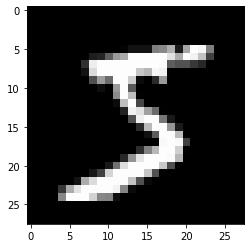

In [39]:
x_train, y_train, x_test, y_test = process_mnist_data()
img = x_train[0].reshape(28, 28, 1)
plt.imshow(img, cmap='gray')

In [40]:
m = parse_input_model()
c1 = ConvolutionLayerBatch(6, 5, 1, 2)
mnist_batch_1 = x_train[0:64].reshape(64, 28, 28, 1)
o = c1.forward(mnist_batch_1)
print(o.shape)

(64, 6, 28, 28)


In [41]:
o[0, :, :, 0]

array([[9.86851380e-01, 9.86851380e-01, 3.15663135e+00, 7.91239468e+00,
        1.40110998e+01, 2.24311106e+01, 3.60908330e+01, 5.10759381e+01,
        6.39607815e+01, 8.12261663e+01, 1.04454942e+02, 1.21048966e+02,
        1.30476285e+02, 1.37940258e+02, 1.41006087e+02, 1.40217556e+02,
        1.29952965e+02, 1.16401296e+02, 1.00993375e+02, 8.16753201e+01,
        5.40329074e+01, 3.54382342e+01, 2.34450626e+01, 1.71768862e+01,
        1.04181153e+01, 3.73905635e+00, 9.86851380e-01, 9.86851380e-01],
       [7.80425441e-02, 7.80425441e-02, 2.24782251e+00, 7.00358584e+00,
        1.31022909e+01, 2.15223018e+01, 3.51820242e+01, 5.01671293e+01,
        6.30519727e+01, 8.03173574e+01, 1.03546133e+02, 1.20140157e+02,
        1.29567476e+02, 1.37031450e+02, 1.40097278e+02, 1.39308747e+02,
        1.29044156e+02, 1.15492487e+02, 1.00084566e+02, 8.07665112e+01,
        5.31240986e+01, 3.45294253e+01, 2.25362538e+01, 1.62680773e+01,
        9.50930643e+00, 2.83024751e+00, 7.80425441e-02, 7.80425

In [42]:
a1 = ActivationLayer()
o1 = a1.forward(o)
o1.shape

(64, 6, 28, 28)

In [43]:
m1 = MaxPoolingLayerBatch(2, 2)
o2 = m1.forward(o1)
o2.shape

IndexError: index 3 is out of bounds for axis 2 with size 3

In [ ]:
x = np.arange(1,25).reshape(2, 3, 4)
x

In [ ]:
y = np.max(x, axis=(1, 2))
y